In [245]:
# 1. Import thư viện cần thiết

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Bidirectional
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

In [246]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_excel('../../Dataset/ETHUSDT.xlsx')
df1=df.reset_index()['Close']

In [247]:
#đảo ngược dữ liệu
df1=df1.loc[::-1].reset_index(drop=True)
df=df.loc[::-1].reset_index(drop=True)

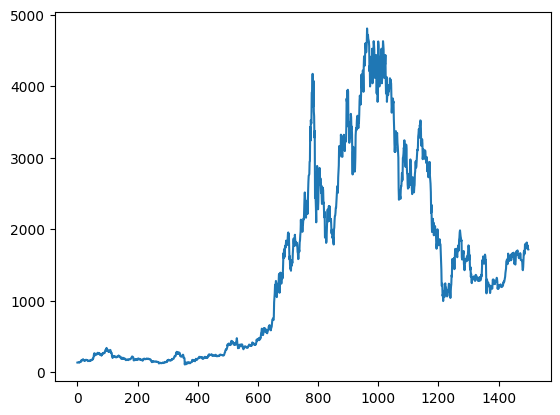

In [248]:
plt.plot(df1)

In [249]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [250]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [251]:
#in shape của từng tập dư liệu
print(train_data.shape, test_data.shape, val_data.shape)

#in head
print(df1[:5])


(900, 1) (300, 1) (300, 1)
[[0.00575087]
 [0.00599129]
 [0.00626787]
 [0.00601469]
 [0.00556577]]


In [252]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [253]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 3
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [254]:
#in shape của từng tập dư liệu
print(X_train.shape, y_train.shape, X_val.shape, yval.shape, X_test.shape, ytest.shape)


(896, 3) (896,) (296, 3) (296,) (296, 3) (296,)


In [255]:
# # 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

#in shape của từng tập dư liệu
print(X_train.shape, X_test.shape, X_val.shape)

(896, 3, 1) (296, 3, 1) (296, 3, 1)


In [256]:
#in dữ liệu
print(X_train[:1])

[[[0.00575087]
  [0.00599129]
  [0.00626787]]]


In [257]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense, Dropout, LSTM #thêm thư viện Dropout để tránh overfitting
from tensorflow.keras.callbacks import EarlyStopping
#import adam
from tensorflow.keras.optimizers import Adam
#import thư viện mean_squared_error
from tensorflow.keras.losses import MeanSquaredError

#import cac metrics nhu mse,mae,rmse
from tensorflow.keras import metrics

#import cac loss function nhu mse,mae,rmse,mape
from tensorflow.keras import losses 

# Tạo model
model = Sequential()

input_shape = (time_step, 1)
model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
model.add(LSTM(32, input_shape=input_shape, return_sequences=True))
model.add(LSTM(16))


model.add(Dense(5))
model.add(Dropout(0.2)) 

model.add(Dense(1))

# Compile model với các tham số: optimizer, loss, metrics 
model.compile (loss= "mean_squared_error", optimizer=Adam(learning_rate=0.0001), metrics="mean_squared_error")
early_stop = EarlyStopping(monitor='val_loss', verbose=1,patience=50, restore_best_weights=True)
#mode = min tìm min của val_loss verbose = 1 in ra thông báo patience = 25 sau 25 epoch mà val_loss không giảm thì dừng lại
#baseline = 0.0001 nếu val_loss nhỏ hơn 0.0001 thì dừng lại
#restore_best_weights = True lấy lại trọng số tốt nhất




In [258]:
#in shape của từng tập dư liệu
print(X_train.shape, X_test.shape, X_val.shape)

(896, 3, 1) (296, 3, 1) (296, 3, 1)


In [259]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=2000,batch_size=64,verbose=1,callbacks=[early_stop])

Epoch 1/2000


14/14 [==============================] - 5s 103ms/step - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.4926 - val_mean_squared_error: 0.4926
Epoch 2/2000
14/14 [==============================] - 0s 9ms/step - loss: 0.0588 - mean_squared_error: 0.0588 - val_loss: 0.4710 - val_mean_squared_error: 0.4710
Epoch 3/2000
14/14 [==============================] - 0s 8ms/step - loss: 0.0550 - mean_squared_error: 0.0550 - val_loss: 0.4494 - val_mean_squared_error: 0.4494
Epoch 4/2000
14/14 [==============================] - 0s 8ms/step - loss: 0.0519 - mean_squared_error: 0.0519 - val_loss: 0.4271 - val_mean_squared_error: 0.4271
Epoch 5/2000
14/14 [==============================] - 0s 10ms/step - loss: 0.0491 - mean_squared_error: 0.0491 - val_loss: 0.4050 - val_mean_squared_error: 0.4050
Epoch 6/2000
14/14 [==============================] - 0s 9ms/step - loss: 0.0462 - mean_squared_error: 0.0462 - val_loss: 0.3817 - val_mean_squared_error: 0.3817
Epoch 7/2000
14/14 [==================

In [260]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

#in shape của từng tập dư liệu
print(train_predict.shape, y_pred.shape, y_pred_val.shape)

10/10 [==============================] - 0s 2ms/step
(896, 1) (296, 1) (296, 1)


In [261]:
#in shape của từng tập dư liệu y real
print(y_train.shape, ytest.shape, yval.shape)


(896,) (296,) (296,)


In [262]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

#in head
print(train_predict[:5])

[[182.46465]
 [183.28857]
 [183.53857]
 [182.41692]
 [181.72946]]


In [263]:
#Chuẩn hóa ngược lại yval và ytest và y_train sau khi đã reshape
y_train = y_train.reshape(y_train.shape[0],1)
ytest = ytest.reshape(ytest.shape[0],1)
yval = yval.reshape(yval.shape[0],1)

y_train=scaler.inverse_transform(y_train)
ytest=scaler.inverse_transform(ytest)
yval=scaler.inverse_transform(yval)

#in head
print(y_train[:5])



[[136.09]
 [133.98]
 [134.18]
 [139.45]
 [137.86]]


In [264]:
# 12. Đánh giá độ chính xác thuật toán bằng MAE va RMSE 
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#Đánh giá độ chính xác thuật toán bằng RMSE
trainScore = math.sqrt(mean_squared_error(y_train,train_predict))
print('Train Score: %.3f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(ytest,y_pred))
print('Test Score: %.3f RMSE' % (testScore))
valScore = math.sqrt(mean_squared_error(yval,y_pred_val))
print('Val Score: %.3f RMSE' % (valScore))

#Đánh giá độ chính xác thuật toán bằng MAE
trainScore = mean_absolute_error(y_train,train_predict)
print('Train Score: %.3f MAE' % (trainScore))
testScore = mean_absolute_error(ytest,y_pred)
print('Test Score: %.3f MAE' % (testScore))
valScore = mean_absolute_error(yval,y_pred_val)
print('Val Score: %.3f MAE' % (valScore))



    
    

Train Score: 117.650 RMSE
Test Score: 205.470 RMSE
Val Score: 107.765 RMSE
Train Score: 70.523 MAE
Test Score: 160.049 MAE
Val Score: 85.663 MAE


In [265]:
# Danh gia model bang mat do MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return numpy.mean(numpy.abs((y_true - y_pred) / y_true)) * 100

print('Train Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_train[:,0], train_predict[:,0]))
print('Test Mean Absolute Percentage Error:', mean_absolute_percentage_error(ytest[:,0], y_pred[:,0]))
print('Val Mean Absolute Percentage Error:', mean_absolute_percentage_error(yval[:,0], y_pred_val[:,0]))
print('Train Score: %.2f MAPE' % (mean_absolute_percentage_error(y_train[:,0], train_predict[:,0])))
print('Test Score: %.2f MAPE' % (mean_absolute_percentage_error(ytest[:,0], y_pred[:,0])))
print('Val Score: %.2f MAPE' % (mean_absolute_percentage_error(yval[:,0], y_pred_val[:,0])))


Train Mean Absolute Percentage Error: 14.4573231266719
Test Mean Absolute Percentage Error: 4.8450921672359915
Val Mean Absolute Percentage Error: 5.94937918106149
Train Score: 14.46 MAPE
Test Score: 4.85 MAPE
Val Score: 5.95 MAPE


In [266]:
# Chuẩn bị dữ liệu cho dự đoán tiếp theo

# Lấy time_step ngày cuối cùng của dữ liệu train để dự đoán 30 ngày tiếp theo
x_input = val_data[-time_step:].reshape(-1, 1)   #[-time_step:] lấy time_step phần tử cuối cùng của dữ liệu
print("x_input.shape = ", x_input.shape)

# Dự đoán 30 ngày tiếp theo
lst_output = []

i = 1  #biến đếm để dừng vòng lặp while
while(i <= 30):
    print("-----------------")
    #dua ve mang array 1 chieu
    list_input = x_input.reshape(1, -1)[0]
    #in ra x_input cuar ngày thứ i trong 30 ngày tiếp theo
    print("day ", i, " have input = ", list_input)

    # Dự đoán giá đóng của ngày tiếp theo
    x_input = x_input.reshape(1, time_step, 1) #reshape lại về dạng (1, time_step, 1)
    yhat = model.predict(x_input, verbose=0) #dự đoán giá đóng của ngày tiếp theo

    #in ra giá đóng của ngày thứ i trong 30 ngày tiếp theo
    print("day ",i," have output = ", yhat[0][0])

    #thêm giá đóng của ngày thứ i vào lst_output
    lst_output.append(yhat[0][0])

    #xoa phan tu dau tien cua x_input
    x_input = np.delete(x_input, 0)
    #them yhat vao x_input
    x_input = np.append(x_input, yhat[0][0])
    
    
    #tang bien dem len 1
    i = i + 1


x_input.shape =  (3, 1)
-----------------
day  1  have input =  [0.35446878 0.34198836 0.34230537]


day  1  have output =  0.3374811
-----------------
day  2  have input =  [0.34198836 0.34230537 0.33748111]
day  2  have output =  0.32929915
-----------------
day  3  have input =  [0.34230537 0.33748111 0.32929915]
day  3  have output =  0.32737485
-----------------
day  4  have input =  [0.33748111 0.32929915 0.32737485]
day  4  have output =  0.3218182
-----------------
day  5  have input =  [0.32929915 0.32737485 0.3218182 ]
day  5  have output =  0.3156502
-----------------
day  6  have input =  [0.32737485 0.3218182  0.31565019]
day  6  have output =  0.312302
-----------------
day  7  have input =  [0.3218182  0.31565019 0.31230199]
day  7  have output =  0.30676666
-----------------
day  8  have input =  [0.31565019 0.31230199 0.30676666]
day  8  have output =  0.30147514
-----------------
day  9  have input =  [0.31230199 0.30676666 0.30147514]
day  9  have output =  0.29734102
-----------------
day  10  have input =  [0.30676666 0.30147514 0.29734102]
day  10  have output = 

In [267]:
#in ra 30 ngày tiếp theo
print("Du doan 30 ngay tiep theo: ", lst_output)

Du doan 30 ngay tiep theo:  [0.3374811, 0.32929915, 0.32737485, 0.3218182, 0.3156502, 0.312302, 0.30676666, 0.30147514, 0.29734102, 0.29202732, 0.28710055, 0.2825964, 0.2775185, 0.27275822, 0.26813176, 0.26326287, 0.25861457, 0.25400776, 0.24932721, 0.24479558, 0.24029015, 0.23579262, 0.23140223, 0.22704774, 0.22273946, 0.2185183, 0.2143473, 0.21024063, 0.20621361, 0.20224902]


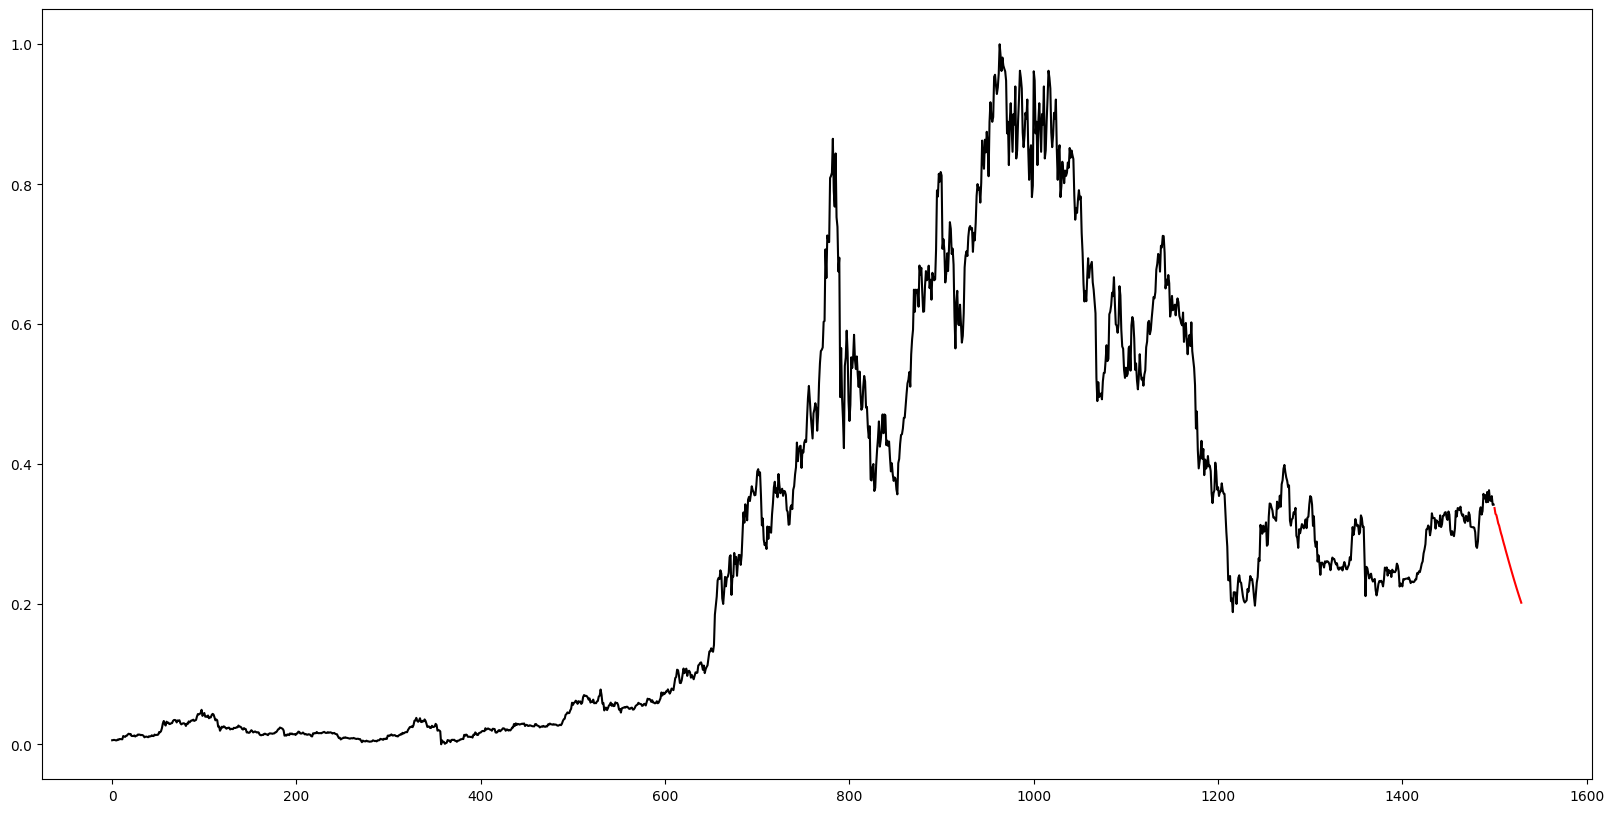

In [268]:
# Tạo mảng index tương ứng với các ngày
days = np.array(range(len(df), len(df) + len(lst_output)))

# Vẽ biểu đồ
plt.figure(figsize=(20,10))
plt.plot(days, lst_output, c='r', label='Next 30 days')
plt.plot(df1, c='black', label='Real data')
plt.show()


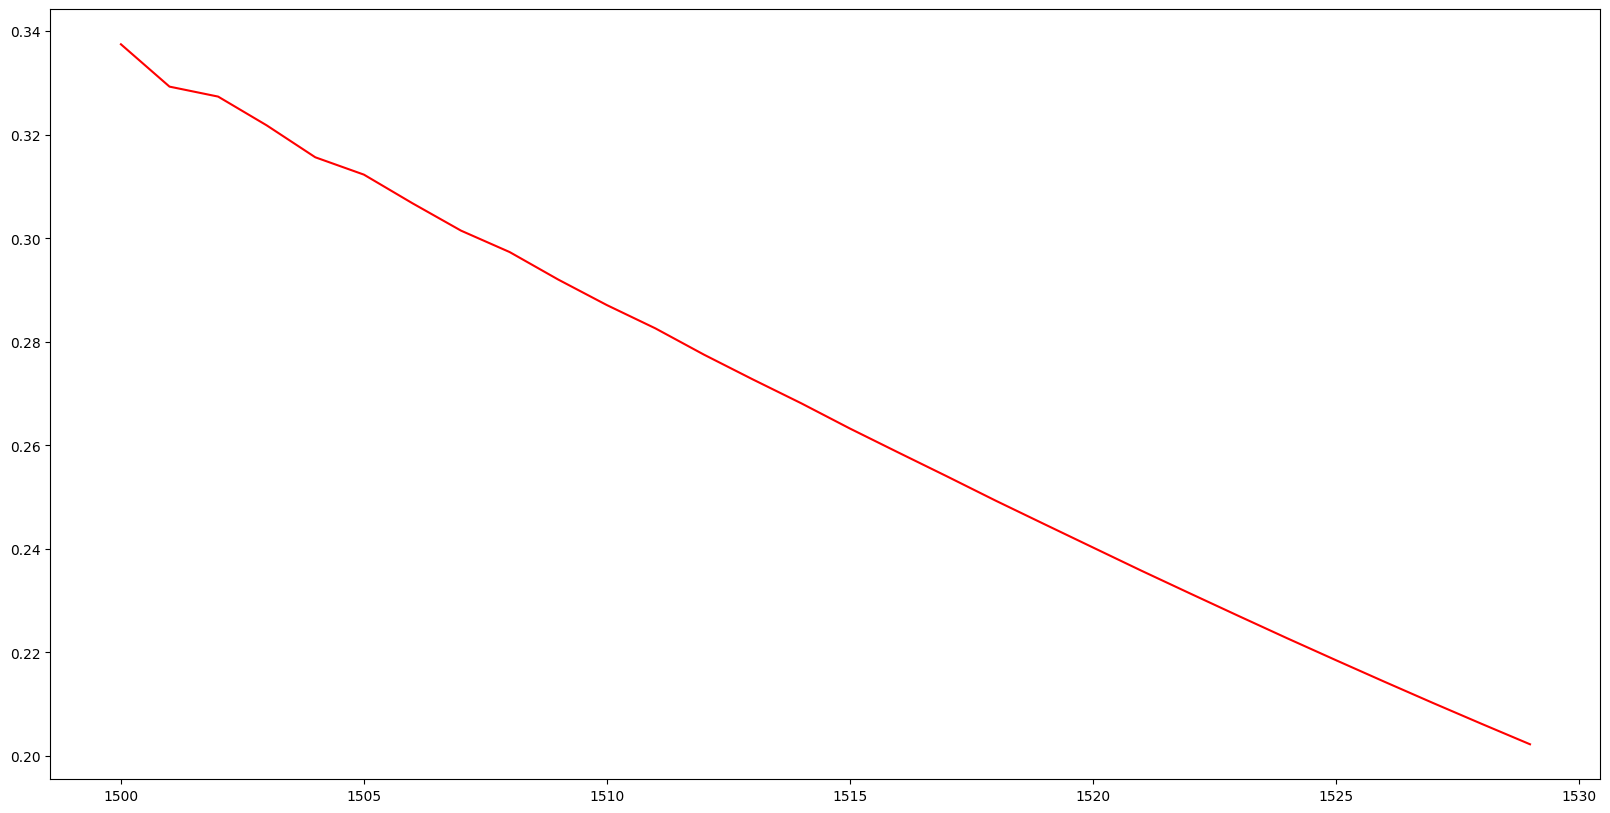

In [269]:
#vẽ next 30 days
plt.figure(figsize=(20,10))
plt.plot(days, lst_output, c='r', label='Next 30 days')
plt.show()

In [270]:
#chuẩn hóa ngược lại dữ liệu

train_data_inverse=scaler.inverse_transform(np.array(train_data).reshape(-1, 1))
test_data_inverse=scaler.inverse_transform(np.array(test_data).reshape(-1, 1))
val_data_inverse=scaler.inverse_transform(np.array(val_data).reshape(-1, 1))
next_30_days_inverse=scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))

# in dữ liệu
print(train_data_inverse[:5])
print(test_data_inverse[:5])
print(val_data_inverse[:5])
print(next_30_days_inverse[:5])

[[134.85]
 [135.98]
 [137.28]
 [136.09]
 [133.98]]
[[3926.77]
 [3434.57]
 [3499.  ]
 [3424.93]
 [3208.86]]
[[1834.08]
 [1775.12]
 [1804.58]
 [1806.23]
 [1859.84]]
[[1694.0353]
 [1655.5787]
 [1646.5342]
 [1620.4171]
 [1591.4265]]


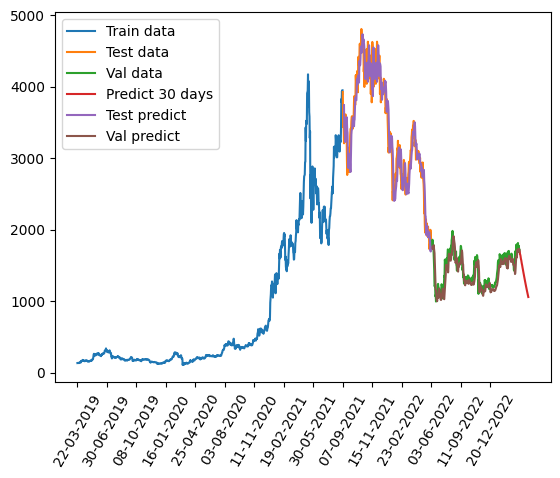

In [271]:
#vẽ y_train nối với ytest và y_val với index tương ứng

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
predict30_data_index = pd.RangeIndex(start=train_size+test_size+val_size, stop=train_size+test_size+val_size+30, step=1)

train_predict_index = pd.RangeIndex(start=0, stop=train_predict.shape[0], step=1)
y_pred_index = pd.RangeIndex(start=train_size+(train_size-train_predict.shape[0]), stop=train_size+(train_size-train_predict.shape[0])+y_pred.shape[0], step=1)
y_pred_val_index = pd.RangeIndex(start=train_size+(train_size-train_predict.shape[0])+y_pred.shape[0]+(val_size-y_pred_val.shape[0]), stop=train_size+(train_size-train_predict.shape[0])+y_pred.shape[0]+y_pred_val.shape[0]+(val_size-y_pred_val.shape[0]), step=1)

plt.plot(train_data_index, train_data_inverse,  label='Train data')
plt.plot(test_data_index, test_data_inverse, label='Test data')
plt.plot(val_data_index, val_data_inverse,  label='Val data')
plt.plot(predict30_data_index, next_30_days_inverse, label='Predict 30 days')
plt.plot(y_pred_index, y_pred, label='Test predict')
plt.plot(y_pred_val_index, y_pred_val,  label='Val predict')
# trục x là giá trị của cột Close time của df1
plt.xticks(np.arange(0, len(df1), 100), df['Close time'][0:len(df):100])
#xoay ngang giá trị của trục x
plt.xticks(rotation=60)
plt.legend()
plt.show()



